In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from chronos import ChronosPipeline
from nixtlats import NixtlaClient
from neuralforecast.models import MLP, NBEATS
from neuralforecast.losses.pytorch import HuberLoss
from neuralforecast.core import NeuralForecast
from IPython.display import clear_output
from tqdm import tqdm
import pickle
import sys
import os

In [2]:
# Add the 'src/utils' directory to the module search path
sys.path.append('../src')

from utils.nextools import *  # Module from 'src/utils' directory
from utils.losses import *  # Module from 'src/utils' for loss functions
from models.student_model import StudentModel

In [3]:
# Path to the YAML file
yaml_file_path = '../config/config.yaml'

# Load the configuration parameters from the YAML file
config = load_yaml_config(yaml_file_path)

# Access the parameters under the 'data' category
data_params = config['data']
# Access the parameters under the 'model' category
model_params = config['model']

# Definindo as sementes para garantir a reprodutibilidade
torch.manual_seed(data_params['default_seed'])
np.random.seed(data_params['default_seed'])

In [4]:
# load dataframes from source
deep_for_this_file = '..'
processed_path = os.path.join(deep_for_this_file, data_params['processed_path'])
intermediate_path = os.path.join(deep_for_this_file, data_params['intermediate_path'])

processed_train_path = os.path.join(processed_path, data_params['processed_train_df'])
processed_test_path = os.path.join(processed_path, data_params['processed_test_df'])

processed_train_df = pd.read_csv(processed_train_path)
processed_test_df  = pd.read_csv(processed_test_path)

crop_target_datetime = data_params['crop_target_datetime']

target_pivot = processed_train_df.loc[processed_train_df.ds == crop_target_datetime,
                                'ds'].index.values[0]

processed_series = np.concatenate([processed_train_df[target_pivot:].y.values,
                             processed_test_df.y.values], axis=None)

processed_ssh = np.concatenate([processed_train_df[target_pivot:].ssh.values,
                          processed_test_df.ssh.values], axis=None)

processed_at = np.concatenate([processed_train_df[target_pivot:]['at'].values,
                         processed_test_df['at'].values], axis=None)

processed_ds = np.concatenate([processed_train_df[target_pivot:].ds.values,
                         processed_test_df.ds.values], axis=None)

In [5]:
# Model Parameters
context_window_len = model_params['context_window_len']  # len of input sequence
forecast_len = model_params['forecast_len']
batch_size = model_params['batch_size']
epochs = model_params['epochs']
lr = model_params['lr']
beta = model_params['beta']  # Weight between hard and soft targets
input_size = model_params['input_size']
hidden_size = model_params['hidden_size']

In [25]:
# Load forecast data from timeGPT
timegpt_fcst_path = os.path.join(intermediate_path, data_params['timegpt_fcst_file'])
y_timegpt = np.array(load_pickle(timegpt_fcst_path))

# Load forecast data from Chronos
chronos_fcst_path = os.path.join(intermediate_path, data_params['chronos_fcst_file'])
y_chronos = np.array(load_pickle(chronos_fcst_path))
y_chronos = y_chronos.reshape((y_chronos.shape[0], y_chronos.shape[2]))

# Create input and output sequences for different data sources
X, y = create_sequences(processed_series, context_window_len, forecast_len)
# X_ds, y_ds = create_sequences(processed_ds, context_window_len, forecast_len)
# X_ssh, y_ssh = create_sequences(processed_ssh, context_window_len, forecast_len)
# X_at, y_at = create_sequences(processed_at, context_window_len, forecast_len)

# Calculate the mean of teacher features from y_timegpt and y_chronos
# y_teacher = np.mean([y_timegpt, y_chronos], axis=0)
y_teacher = y_chronos

# Calculate the index to split data into training and test sets
split_idx = processed_train_df.shape[0] - target_pivot - (context_window_len + forecast_len - 1)

# Split input and output sequences into training and test sets
X_train, X_test = split_data(X, split_idx)
y_train, y_test = split_data(y, split_idx)

# X_train_ds, X_test_ds = split_data(X_ds, split_idx)
# y_train_ds, y_test_ds = split_data(y_ds, split_idx)

# X_train_ssh, X_test_ssh = split_data(X_ssh, split_idx)
# y_train_ssh, y_test_ssh = split_data(y_ssh, split_idx)

# X_train_at, X_test_at = split_data(X_at, split_idx)
# y_train_at, y_test_at = split_data(y_at, split_idx)

# Split teacher features (foundation models prediction) into training and test sets
y_train_timegpt, y_test_timegpt = split_data(y_timegpt, split_idx)
y_train_chronos, y_test_chronos = split_data(y_chronos, split_idx)
y_train_teacher, y_test_teacher = split_data(y_teacher, split_idx)

# Convert numpy arrays to PyTorch tensors and move them to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert training data to tensors
X_train_tensor = torch.from_numpy(X_train).unsqueeze(-1).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
y_train_teacher_tensor = torch.from_numpy(y_train_teacher).float().to(device) #distillation

# Convert test data to tensors
X_test_tensor  = torch.from_numpy(X_test).unsqueeze(-1).float().to(device)
y_test_tensor  = torch.from_numpy(y_test).float().to(device)
y_test_teacher_tensor = torch.from_numpy(y_test_teacher).float().to(device) #distillation

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, y_train_teacher_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Train `StudentModel`with regular loss

In [7]:
# Instantiate student model (smaller model)
student_model = StudentModel(input_size=input_size,
                            hidden_size=hidden_size,
                            output_size=forecast_len).to(device)

criterion_fn = ioa_loss  # Choose and define the loss function
optimizer_student = optim.Adam(student_model.parameters(), lr=lr)   # Define the optimizer
student_losses = [] # Lists to store losses
student_model.train()   # Train student model

for epoch in range(epochs): # Loop over epochs
    total_loss = 0
    for batch_x, batch_y, batch_y_teacher in train_loader:  # Loop over batches in the dataloader
        optimizer_student.zero_grad()   # Zero the gradients
        student_outputs = student_model(batch_x)    # Get student model predictions
        loss = criterion_fn(student_outputs, batch_y)   # Calculate the loss
        loss.backward() # Backpropagate the loss
        optimizer_student.step()    # Update the model parameters
        total_loss += loss.item()   # Acumulate the loss
    student_losses.append(total_loss / len(train_loader))

    print(f"Student Epoch {epoch + 1} | Student Loss: {student_losses[-1]}")

Student Epoch 1 | Student Loss: 0.6070619996001081
Student Epoch 2 | Student Loss: 0.5267768327782794
Student Epoch 3 | Student Loss: 0.2960336891616263
Student Epoch 4 | Student Loss: 0.08895259659464766
Student Epoch 5 | Student Loss: 0.07927910293020853
Student Epoch 6 | Student Loss: 0.07782390786380303
Student Epoch 7 | Student Loss: 0.07685464765967392
Student Epoch 8 | Student Loss: 0.07521893047704929
Student Epoch 9 | Student Loss: 0.07535808842356612
Student Epoch 10 | Student Loss: 0.07310224742424197
Student Epoch 11 | Student Loss: 0.07147872884099077
Student Epoch 12 | Student Loss: 0.0706871442678498
Student Epoch 13 | Student Loss: 0.07099238256128823
Student Epoch 14 | Student Loss: 0.06874074296253484
Student Epoch 15 | Student Loss: 0.06835628573487444
Student Epoch 16 | Student Loss: 0.06700054465270625
Student Epoch 17 | Student Loss: 0.06566416344991545
Student Epoch 18 | Student Loss: 0.06379171987859214
Student Epoch 19 | Student Loss: 0.061752966264399085
Stude

### Train `StudentModel`with `DistillationLoss`

In [8]:
# Instantiate student model (smaller model) with distillation Loss
distil_student_model = StudentModel(input_size=1,
                            hidden_size=64,
                            output_size=forecast_len).to(device)

distil_criterion_fn = DistillationLoss(loss_function=ioa_loss, beta=beta)  # Initialize distillation loss
optimizer_student = optim.Adam(distil_student_model.parameters(), lr=lr)   # Define the optimizer
distil_losses = [] # Lists to store losses
distil_student_model.train()   # Train student model

for epoch in range(epochs): # Loop over epochs
    total_loss = 0
    for batch_x, batch_y, batch_y_teacher in train_loader:  # Loop over batches in the dataloader
        optimizer_student.zero_grad()   # Zero the gradients
        student_outputs = distil_student_model(batch_x)    # Get student model predictions
        teacher_outputs = batch_y_teacher  # Get teacher model predictions
        loss = distil_criterion_fn(batch_y, student_outputs, teacher_outputs)  # Calculate the combined loss
        loss.backward() # Backpropagate the loss
        optimizer_student.step()    # Update the model parameters
        total_loss += loss.item()   # Acumulate the loss
    distil_losses.append(total_loss / len(train_loader))

    print(f"Student Epoch {epoch + 1} | Distillation Student Loss: {distil_losses[-1]}")

Student Epoch 1 | Distillation Student Loss: 0.5998841640425892
Student Epoch 2 | Distillation Student Loss: 0.5310676315935646
Student Epoch 3 | Distillation Student Loss: 0.3223091967222167
Student Epoch 4 | Distillation Student Loss: 0.1996541045060972
Student Epoch 5 | Distillation Student Loss: 0.19304567575454712
Student Epoch 6 | Distillation Student Loss: 0.18762613215097568
Student Epoch 7 | Distillation Student Loss: 0.18161441712844661
Student Epoch 8 | Distillation Student Loss: 0.17528884221867816
Student Epoch 9 | Distillation Student Loss: 0.1737425181923843
Student Epoch 10 | Distillation Student Loss: 0.1725891501438327
Student Epoch 11 | Distillation Student Loss: 0.1698383507205219
Student Epoch 12 | Distillation Student Loss: 0.1705323072468362
Student Epoch 13 | Distillation Student Loss: 0.1684896386251217
Student Epoch 14 | Distillation Student Loss: 0.16622705866650836
Student Epoch 15 | Distillation Student Loss: 0.1661186843383603
Student Epoch 16 | Distillati

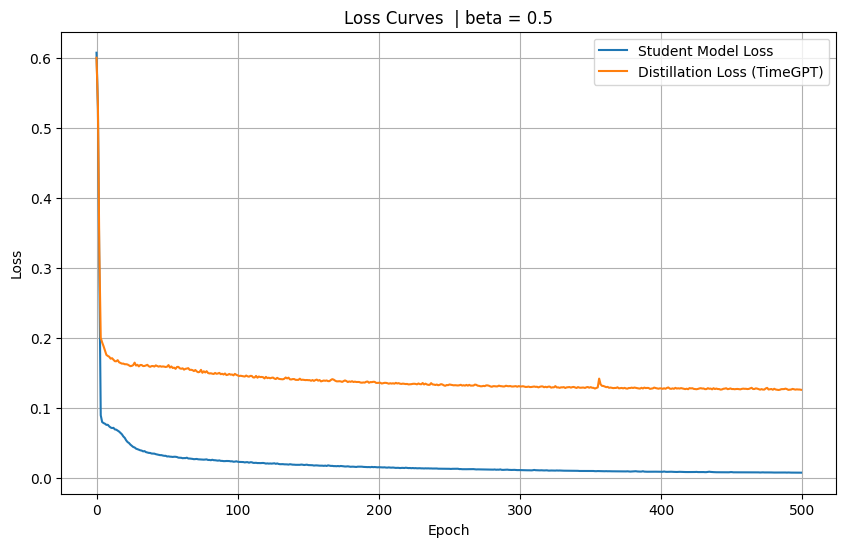

In [9]:
# Plot loss curves for teacher and student models
plt.figure(figsize=(10, 6))
#plt.plot(teacher_losses, label='Teacher Model Loss')
plt.plot(student_losses, label='Student Model Loss')
plt.plot(distil_losses, label='Distillation Loss (TimeGPT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curves  | beta = {beta}')
plt.legend()
plt.grid(True)
plt.show()



Plot from train evaluation

Distillation


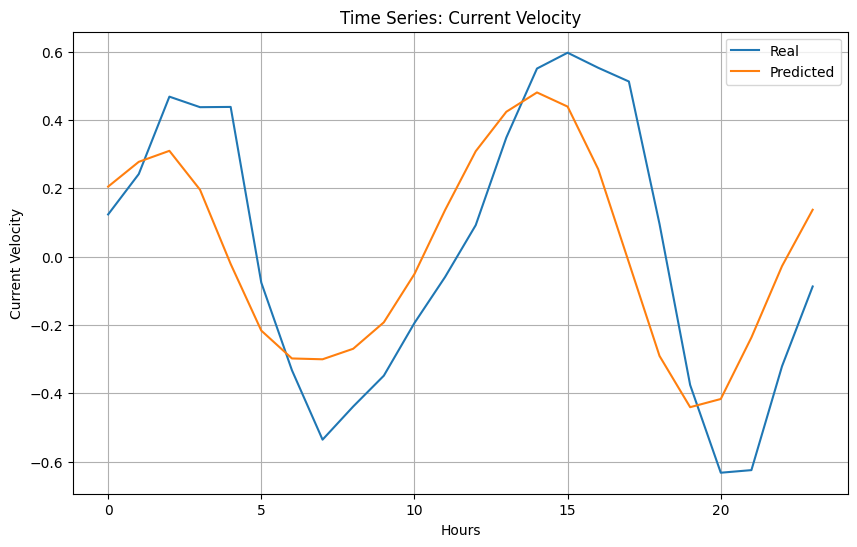


Student


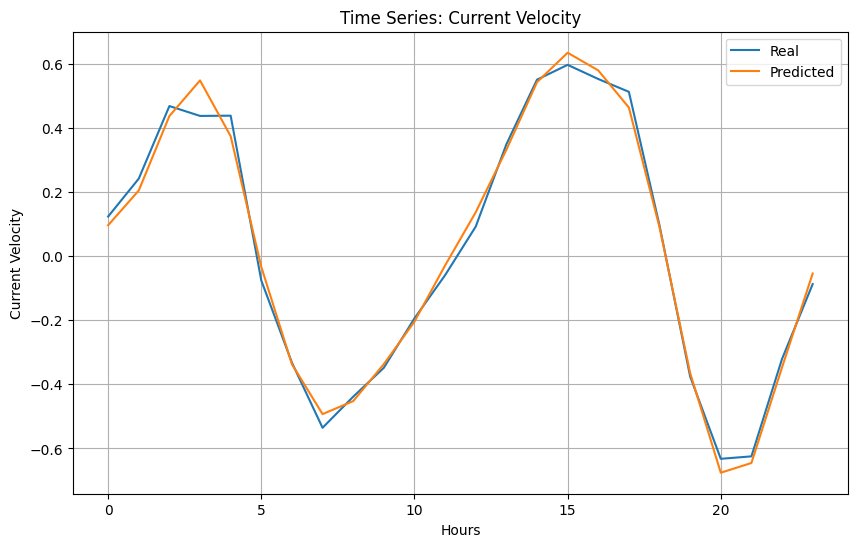

Student Model Index of Agreement (IoA): 0.9931132824186565
Distillation Student Model Index of Agreement (IoA): 0.8736728017287518


In [10]:
student_model.eval()
with torch.no_grad():
    student_train_predictions = student_model(X_train_tensor).cpu().numpy()

# Calculate IoA for teacher and student models
# ioa_train_teacher = calculate_ioa(y_train, teacher_train_predictions)
ioa_train_student = calculate_ioa(y_train, student_train_predictions)

distil_student_model.eval()
with torch.no_grad():
    distil_student_train_predictions = distil_student_model(X_train_tensor).cpu().numpy()

# Calculate IoA for teacher and student models
# ioa_train_teacher = calculate_ioa(y_train, teacher_train_predictions)
distil_ioa_train_student = calculate_ioa(y_train, distil_student_train_predictions)

print('\n\nPlot from train evaluation\n')
print('Distillation')
plot_time_series(y_train[0], distil_student_train_predictions[0])
print('\nStudent')
plot_time_series(y_train[0], student_train_predictions[0])

# print("Teacher Model Index of Agreement (IoA):", ioa_train_teacher)
print("Student Model Index of Agreement (IoA):", ioa_train_student)
print("Distillation Student Model Index of Agreement (IoA):", distil_ioa_train_student)



Plot from test evaluation

Distillation
Distillation Student Model Index of Agreement (IoA): 0.9265186852355654


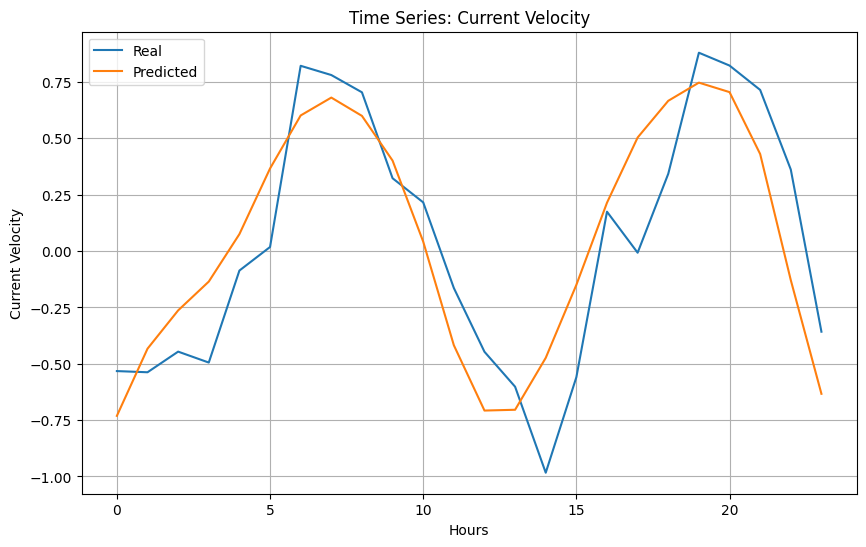


Student
Student Model Index of Agreement (IoA): 0.9633099275922106


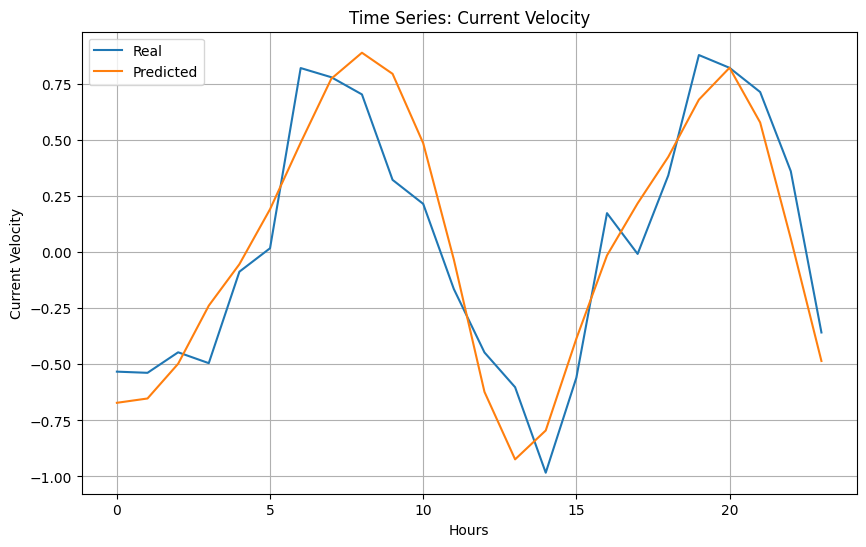

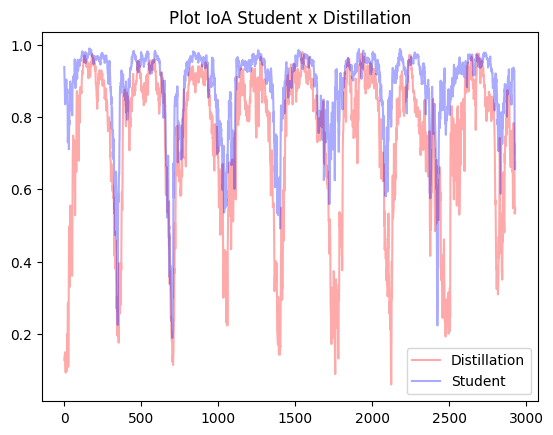

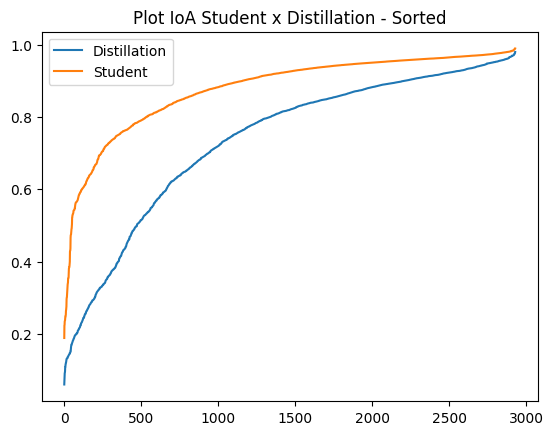

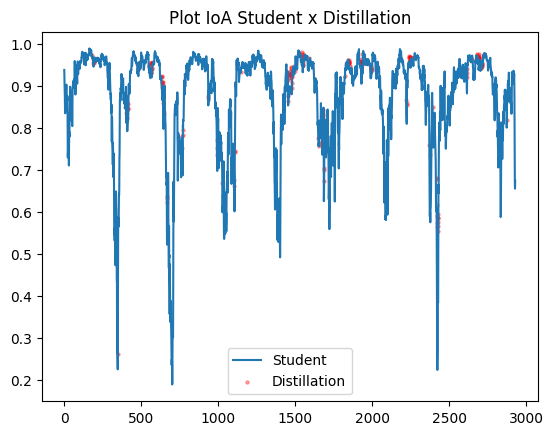

In [11]:
# Test evaluation for student model
student_model.eval()
with torch.no_grad():
    student_test_predictions = student_model(X_test_tensor).cpu().numpy()

# Calculate IoA for student model
ioa_test_student = [calculate_ioa(_y, _pred) for _y, _pred in zip(y_test, student_test_predictions)]

# Test evaluation for distilled student model
distil_student_model.eval()
with torch.no_grad():
    distil_student_test_predictions = distil_student_model(X_test_tensor).cpu().numpy()

# Calculate IoA for distilled student model
distil_ioa_test_student = [calculate_ioa(_y, _pred) for _y, _pred in zip(y_test, distil_student_test_predictions)]

# Print and plot test evaluation results
print('\n\nPlot from test evaluation\n')
print('Distillation')
print("Distillation Student Model Index of Agreement (IoA):", calculate_ioa(y_test[200], distil_student_test_predictions[200]))
plot_time_series(y_test[200], distil_student_test_predictions[200])
print('\nStudent')
print("Student Model Index of Agreement (IoA):", calculate_ioa(y_test[200], student_test_predictions[200]))
plot_time_series(y_test[200], student_test_predictions[200])

# Calculate IoA for all test data
list_ioa_test_student = [calculate_ioa(_y, _pred) for _y, _pred in zip(y_test, student_test_predictions)]
list_distil_ioa_test_student = [calculate_ioa(_y, _pred) for _y, _pred in zip(y_test, distil_student_test_predictions)]

print('\n\n')

# Plot IoA for student and distilled student models
plt.title('Plot IoA Student x Distillation')
plt.plot(list_distil_ioa_test_student, color='#FF000055', label='Distillation')
plt.plot(list_ioa_test_student, color='#0000FF55', label='Student')
plt.legend()
plt.show()

print('\n\n')

# Plot sorted IoA for student and distilled student models
plt.title('Plot IoA Student x Distillation - Sorted')
plt.plot(np.sort(list_distil_ioa_test_student), label='Distillation')
plt.plot(np.sort(list_ioa_test_student), label='Student')
plt.legend()
plt.show()

print('\n\n')

# Plot IoA and best predicted points form distillation model
list_x = [i for i, (distil_ioa, ioa) in enumerate(zip(list_distil_ioa_test_student, list_ioa_test_student)) if distil_ioa > ioa]
list_y = [distil_ioa for distil_ioa, ioa in zip(list_distil_ioa_test_student, list_ioa_test_student) if distil_ioa > ioa]

plt.title('Plot IoA Student x Distillation')
plt.plot(list_ioa_test_student, label='Student')
plt.scatter(list_x, list_y, color='#FF000055', label='Distillation', s=5)
plt.legend()
plt.show()

100%|██████████| 4225/4225 [00:00<00:00, 19897.21it/s]


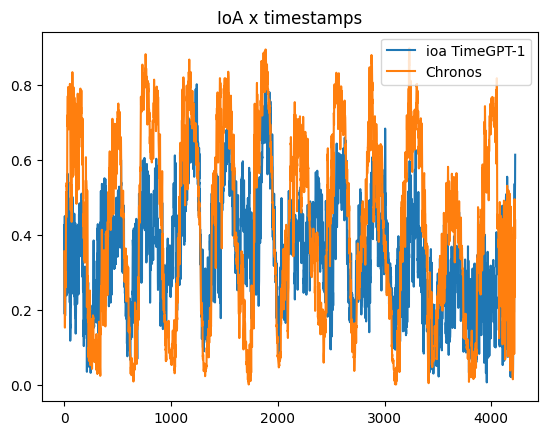

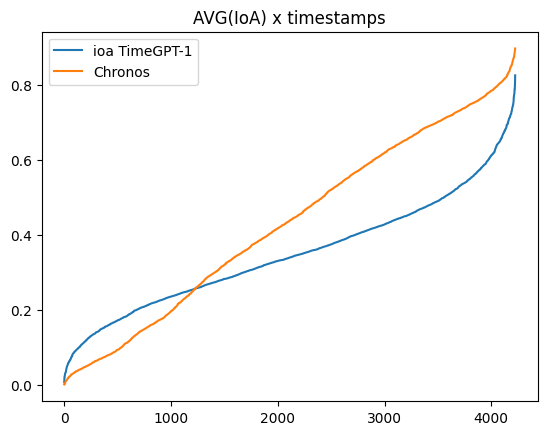

In [12]:
list_ioa_timegpt = []
list_ioa_chronos = []

list_ioa_timegpt = [calculate_ioa(y[i], y_timegpt[i]) for i in tqdm(range(len(y)))]
list_ioa_chronos = [calculate_ioa(y[i], y_chronos[i]) for i in tqdm(range(len(y)))]

plt.plot(list_ioa_timegpt,label='ioa TimeGPT-1')
plt.plot(list_ioa_chronos,label='Chronos')
plt.legend()
plt.title('IoA x timestamps')
plt.show()

plt.plot(np.sort(list_ioa_timegpt),label='ioa TimeGPT-1')
plt.plot(np.sort(list_ioa_chronos),label='Chronos')
plt.legend()
plt.title('AVG(IoA) x timestamps')
plt.show()

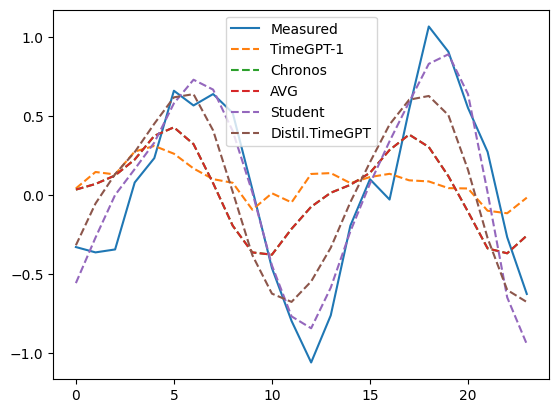

IoA TimeGPT-1:      0.2404647556587136
IoA Chronos:        0.5604781857666428
IoA AVG:            0.5604781857666428
IoA Student:        0.9714282260519815
IoA Distil.TimeGPT: 0.8882724818009301


In [19]:
idx_plot = 500

plt.plot(y_test[idx_plot],label='Measured')
plt.plot(y_test_timegpt[idx_plot],'--',label='TimeGPT-1')
plt.plot(y_test_chronos[idx_plot],'--',label='Chronos')
plt.plot(y_test_teacher[idx_plot],'--',label='AVG')
plt.plot(student_test_predictions[idx_plot],'--',label='Student')
plt.plot(distil_student_test_predictions[idx_plot],'--',label='Distil.TimeGPT')

plt.legend()
plt.show()

print(f'IoA TimeGPT-1:      {calculate_ioa(y_test[idx_plot], y_test_timegpt[idx_plot])}')
print(f'IoA Chronos:        {calculate_ioa(y_test[idx_plot], y_test_chronos[idx_plot])}')
print(f'IoA AVG:            {calculate_ioa(y_test[idx_plot], y_test_teacher[idx_plot])}')
print(f'IoA Student:        {calculate_ioa(y_test[idx_plot], student_test_predictions[idx_plot])}')
print(f'IoA Distil.TimeGPT: {calculate_ioa(y_test[idx_plot], distil_student_test_predictions[idx_plot])}')

In [15]:
np.mean(list_ioa_chronos)

0.4309040833364116